In [340]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-05-30 18:59:29,942: Credentials are already in use. The existing account in the session will be replaced.


# Measurement Error Mitigation

1.  Tworzymy układ w którym dokonujemy pomiaru na wejściu, uruchamiamy układ wiele razy i dla każdego wejścia zapisujemy wektor wynikowy - prawdopodobieństwa odczytania kolejnych wartości (np dla 2 qubitów (P(|00>), P(|01>), P(|10>), P(|11>)))  
3.  Konstruujemy macierz M traktując wektory wynikowe jako kolumny (kolejność kolumn to kolejność wejść do układu tj pierwsza kolumna to wyniki uzyskane dla |0..0>, druga dla |0..1> etc)  
4.  Liczymy macierz odwrotną do macierzy M - N
5. Żeby zmniejszyć błędy wynik uzyskany po uruchomieniu wybranego układu mnożymy przez macierz N
  
W Qiskit ignis znajdują się gotowe metody, w szczególności macierzy M nie trzeba odwracać (może sie nie dać), a w zamian używany jest fitter oparty na metodzie najmneijszych kwadratów.  

Przetestuję działanie measurement error mitigation na  błądzeniu przypadkowym z liczbą kroków = 2

In [306]:
#algorytm błądzenia przypadkowego dla 3 qubitóq
inc = QuantumCircuit(3)
inc.ccx(0,1,2)
inc.cx(0,1)
inc.draw()

dec = QuantumCircuit(3)
dec.x(0)
dec.x(1)
dec.ccx(0,1,2)
dec.x(1)
dec.cx(0,1)
dec.x(0)
dec.draw()

random_walk_step = QuantumCircuit(3)
random_walk_step.h(0)
random_walk_step = random_walk_step + inc + dec 
random_walk_step.draw()

def random_walk(step):
    random_walk = random_walk_step.copy()
    for s in range(step-1):
        random_walk += random_walk_step
    return random_walk

measured = QuantumCircuit(3, 2)
measured.barrier([1,2])
measured.measure([1,2],[0,1])

In [341]:
qc = random_walk(2) + measured

In [342]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

# przygotowanie zbioru obwodów dla stanów bazowych dla 2 qubitów
meas_calibs, state_labels = complete_meas_cal(qr=QuantumRegister(2), circlabel='mcal')

In [343]:
# Wykonanie obwodów kalibrujących dla ibmqx2
backend = provider.get_backend('ibmqx2')
job = execute(meas_calibs, backend=backend, shots=1024, optimization_level = 0)
cal_results = job.result()

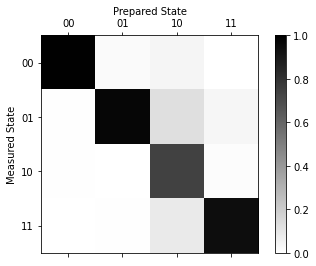

In [344]:
#uzyskana macierz kalibracji
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_fitter.plot_calibration()

In [345]:
results = execute(qc, backend=backend, shots=1024).result()

noisy_counts = results.get_counts()
print(noisy_counts)

{'01': 146, '10': 258, '11': 88, '00': 532}


In [346]:
meas_filter = meas_fitter.filter
print(meas_filter.cal_matrix)
print(meas_filter.state_labels)
print(noisy_counts)

mitigated_counts = meas_filter.apply(noisy_counts, method = 'pseudo_inverse')
print(mitigated_counts)

[[0.99121094 0.02246094 0.04199219 0.00195312]
 [0.00390625 0.97265625 0.12792969 0.03710938]
 [0.00488281 0.         0.74414062 0.01171875]
 [0.         0.00488281 0.0859375  0.94921875]]
['00', '01', '10', '11']
{'01': 146, '10': 258, '11': 88, '00': 532}
{'00': 519.8129553834831, '01': 100.65612789088121, '10': 342.33408562983334, '11': 61.196831095802864}


In [347]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1024)
result = job.result()
quasm_counts = result.get_counts(qc)

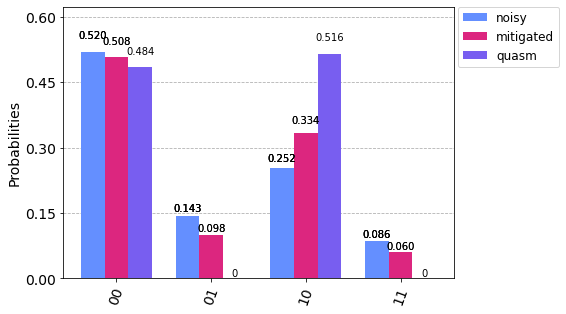

In [348]:
plot_histogram([noisy_counts, mitigated_counts, quasm_counts], legend=['noisy', 'mitigated', 'quasm'])

WYNIKI i WNIOSKI:  
Winik udało się ledwie nieznacznie poprawić. Jest to związane z faktem, że metoda stara się zniwelowac błędy wprowadzone przez pomiar, a w przypadku błądzenia przypadkowego jest duzo bramek (i wprowadzanych przez nie błedów) w porównaniu do liczby mierzonych qubitów.